Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

In their first Kaggle competition, Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams! 

In [175]:
import os
import pandas as pd
import copy
import subprocess
import matplotlib as plt
import warnings
import seaborn as sns
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

In [72]:
cwd = os.getcwd()

In [74]:
#list all files in data folder
print(subprocess.check_output(['ls','data/']).decode('UTF-8'))

date_master.xlsx
raw_data
sample_submission.csv
store.csv
test.csv
train.csv



In [117]:
'''
importing all files, considering onle two files test 
and store since sales data is not available in test station
'''
store = pd.read_csv(cwd+'/data/store.csv')
test = pd.read_csv(cwd+'/data/test.csv')
train = pd.read_csv(cwd+'/data/train.csv')
date_master = pd.read_excel(cwd+'/data/date_master.xlsx', sheet_name='date_master')

In [118]:
train.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [119]:
#train.describe(include='all')
train.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [120]:
store.head(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* **Id** - an Id that represents a (Store, Date) duple within the test set
* **Store** - a unique Id for each store
* **Sales** - the turnover for any given day (this is what you are predicting)
* **Customers** - the number of customers on a given day
* **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
* **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
* **StoreType** - differentiates between 4 different store models: a, b, c, d
* **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
* **CompetitionDistance** - distance in meters to the nearest competitor store
* **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
* **Promo** - indicates whether a store is running a promo on that day
* **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
* **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [121]:
sales = copy.deepcopy(train)

In [122]:
#replacing categories in StateHoliday column 
holmap = {'0':0, 'a':'public holiday', 'b':'easter holiday', 'c':'christmas holiday', 0:0}
sales.StateHoliday = sales.StateHoliday.map(holmap)

In [123]:
sales.StateHoliday.unique()

array([0, 'public holiday', 'easter holiday', 'christmas holiday'],
      dtype=object)

In [124]:
date_master.head(2)

,date,year,month_num,day,weekday_num,iso_weeknum,weekday,month,seasons,quarter,holiday_key,holidays,holiday_type,regions_observed
0,2013-01-01,2013,1,1,3,1,Tuesday,January,Winter,1,1-January,New Year's Day,National holiday,0
1,2013-01-02,2013,1,2,4,1,Wednesday,January,Winter,1,2-January,NaN,NaN,NaN


In [126]:
sales.rename(columns={'Date':'date'}, inplace=True)
date_master.rename(columns={'date ':'date'}, inplace=True)
sales['date']=pd.to_datetime(sales['date'])
sales = sales.merge(date_master, how='left', on='date', suffixes={'','_dm'})

In [131]:
sales=sales[['Store', 'date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'year', 'day',
       'iso_weeknum', 'weekday', 'month', 'seasons', 'quarter',
       'holidays', 'holiday_type', 'regions_observed']]

In [145]:
sales.columns

Index(['Store', 'date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'year', 'day', 'iso_weeknum', 'weekday', 'month',
       'seasons', 'quarter', 'holidays', 'holiday_type', 'regions_observed'],
      dtype='object')

In [220]:
df1 = sales[(sales['StateHoliday']!=0)&(sales['regions_observed']!=0)&(sales['regions_observed'].notna())]
df1 = df1[['Store','regions_observed']].drop_duplicates()
df_hol=df1.groupby(by='regions_observed').agg('count').reset_index()
df2=df1.drop_duplicates()

In [230]:
#df2[df2['regions_observed']!='All except\xa0BB']
#df2['regions_observed'].unique()

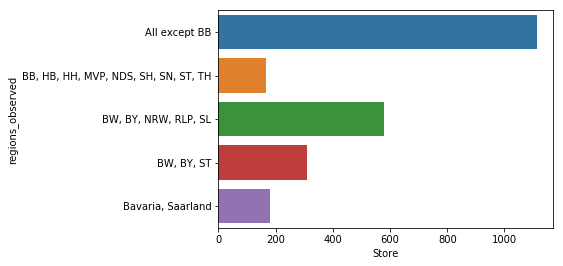

In [207]:
ax = sns.barplot(x=df_hol.Store, y=df_hol.regions_observed)